In [79]:
from scipy.stats import mode
import numpy as np
from PreProcess import preprocess
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = preprocess("housing_data.csv", "MEDV", ["RM", "AGE", "DIS", "LSTAT"])

In [9]:
def L0_norm(y_true, y_pred):
    return np.count_nonzero(y_true - y_pred)

def L1_norm(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred))

def L2_norm(y_true, y_pred):
    return np.sqrt(np.sum((y_true - y_pred) ** 2))

def infinity_norm(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred))

In [61]:
def calculate_error_norm(alpha, beta, x, y, norm_func):
    y_pred = alpha * x + beta
    return norm_func(y, y_pred)

In [67]:
def update_alpha(x, y, beta, norm_func, alpha_range=(-30, 30), grid_points=100):
    best_alpha = None
    min_loss = float('inf')
    for candidate_alpha in np.linspace(*alpha_range, grid_points):
        loss = calculate_error_norm(candidate_alpha, beta, x, y, norm_func)
        if loss < min_loss:
            min_loss = loss
            best_alpha = candidate_alpha
    return best_alpha

def update_beta(x, y, alpha, norm_func, beta_range=(-30, 30), grid_points=100):
    best_beta = None
    min_loss = float('inf')
    for candidate_beta in np.linspace(*beta_range, grid_points):
        loss = calculate_error_norm(alpha, candidate_beta, x, y, norm_func)
        if loss < min_loss:
            min_loss = loss
            best_beta = candidate_beta
    return best_beta

def alternate_optimization(x, y, max_iter, threshold, alpha, beta, norm_func, alpha_range=(-25, 25), beta_range=(-25, 25), grid_points=100):
    for iteration in range(max_iter):
        new_alpha = update_alpha(x, y, beta, norm_func, alpha_range, grid_points)
        new_beta = update_beta(x, y, new_alpha, norm_func, beta_range, grid_points)
        if abs(new_alpha - alpha) < threshold and abs(new_beta - beta) < threshold:
            return new_alpha, new_beta
        alpha, beta = new_alpha, new_beta
    return alpha, beta

In [81]:
def optimize_multiple_features(df, target_column, feature_columns, norm_functions, max_iter=100, threshold=1e-6):
    results = {}
    for feature in feature_columns:
        x = df[feature]
        y = df[target_column]
        results[feature] = {}
        for norm_func in norm_functions:
            norm_name  =  norm_func.__name__
            alpha, beta = alternate_optimization(
                x, y, max_iter, threshold, 0.0, 0.0, norm_func
            )
            error = calculate_error_norm(alpha, beta, x, y, norm_func)
            results[feature][norm_name] = {'alpha': alpha, 'beta': beta, 'error':error }
    return results

In [82]:
 results = optimize_multiple_features(df, 'MEDV', ["RM", "AGE", "DIS", "LSTAT"] , [L0_norm,L1_norm,L2_norm,infinity_norm], max_iter=100, threshold=1e-6)

In [83]:
def generate_graphical_table(data, columns, title):
    df = pd.DataFrame(data, columns=columns)
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.title(title)
    plt.show()

In [88]:
def display_tables_by_norm(results, title_prefix="Results"):
    norm_tables = {}
    for norm_name in set(norm for feature in results.values() for norm in feature):
        table_data = []
        for feature, norms in results.items():
            if norm_name in norms:
                params = norms[norm_name]
                row = [feature, params['alpha'], params['beta'], params['error']]
                table_data.append(row)
        
        # Generate table for each norm
        columns = ["Feature", "Slope", "Bias","Error"]
        title = f"{title_prefix} ({norm_name})"
        generate_graphical_table(table_data, columns, title)
        print("*"*50)

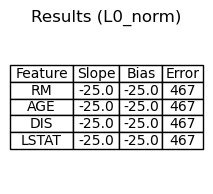

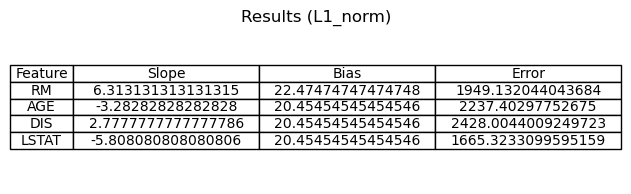

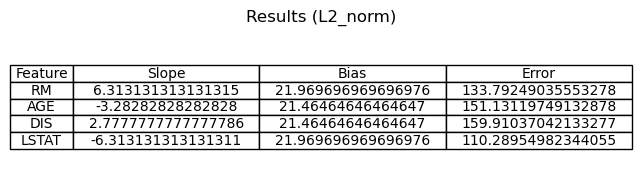

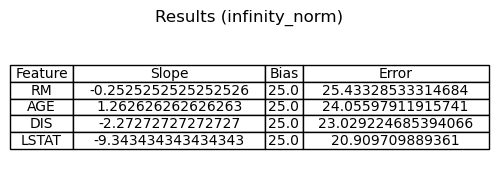

In [89]:
display_tables_by_norm(results)